In [3]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [4]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(0)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):

#   reward for clearing list
    if not any(queues):
        return 25
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1
    
        
def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time < -9.9:
        waiting_time = -9.9

def generate_random_numbers():
    random_sum = random.uniform(0.8, 1.5)  # Generate a random sum between 0.8 and 1.0
    random_numbers = []
    
    
    for _ in range(2):
        random_value = round(random.uniform(0.0, random_sum), 2)  # Generate a random value between 0.0 and the remaining sum with a maximum of one decimal place
        random_numbers.append(random_value)
        random_sum -= random_value

    random_numbers.append(round(random_sum, 1))  # Append the remaining sum to the list with a maximum of one decimal place
    if random_numbers == [0.3,0.4,0.4]: # make sure final numbers dont appear in the training phase
        random_numbers = generate_random_numbers() 
    
    return random_numbers

In [5]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self, q1rate, q2rate, q3rate):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(10000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [q1rate, q2rate, q3rate]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        self.current_queue = 0
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
       # if action < 3 and len(self.queues[action]) > 0:
        #    self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        #append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            #add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        #UPDATING ENVIRONMENT
        if action == 0 and len(self.queues[self.current_queue]) > 0:
            self.queues[self.current_queue].pop(0)
        elif action == 1:
            if self.current_queue == 0:
                self.current_queue = 2
            else:
                self.current_queue -= 1
        elif action == 2:
            if self.current_queue == 2:
                self.current_queue = 0
            else:
                self.current_queue += 1
    
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        observationUpdate = []        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue\
            current_waiting_time = calc_mean_delay(current_queue)
            observationUpdate.append(current_waiting_time)       
            
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
#         done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        #print(f"WAITING TIMES {np.array(waiting_times)}")
        waiting_times = discretize(observationUpdate)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
    
    def change_arrival_rates(self,q1,q2,q3):
        self.arrival_rate = [q1,q2,q3]
        
    def render(self):
        pass

In [6]:
env = TrafficGenerator(0.3,0.25,0.4)
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(10000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [7]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters


#total_episodes = 1500
total_test_episodes = 50
max_steps = 100
learning_rate = 0.1
gamma = 0.3
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
def train_model(gamma, learning_rate, total_episodes):
    rewardstest = []
    # Hyperparameters
    total_episodes = total_episodes
    total_test_episodes = 50
    max_steps = 100
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay_rate = 0.01
    for episode in range(total_episodes):
        arr_rates = generate_random_numbers()
        env.change_arrival_rates(arr_rates[0], arr_rates[1], arr_rates[2])
        state = env.reset()
        total_rewards = 0
        #print("Episode ", episode,"/", total_episodes )
        for step in range(max_steps):
            exp_exp_tradeoff = random.uniform(0, 1)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state, :])
            else:
                action = env.action_space.sample()

            new_state, reward, done, info = env.step(action)
            total_rewards += reward
            #print(new_state)
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
            state = new_state
    #         print(reward)
            if done: 
                rewardstest.append(total_rewards)
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))
    return rewardstest

rewardstest = train_model(0.1,0.1,1500)

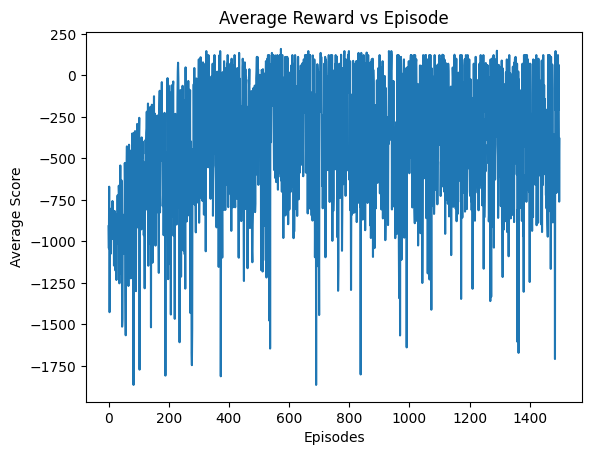

In [8]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n

    
plt.plot(rewardstest)
# Show the plot\n",
plt.title('Average Reward vs Episode')
plt.xlabel('Episodes')
plt.ylabel('Average Score')

plt.show()


In [9]:
print(np.mean(rewardstest))


-415.6773333333333


In [10]:
from itertools import product
# Create a list to store the results
results = []

gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
learning_rate_values = [0.1, 0.2, 0.3, 0.4, 0.5]

# Perform grid search
for gamma, learning_rate in product(gamma_values, learning_rate_values):
    action_size = env.action_space.n
    state_size = env.observation_space.n
    qtable = np.zeros((state_size, action_size))    
    # Training loop
    rewards = train_model(gamma, learning_rate, 400)
    # Evaluate the learned Q-table using a test set or simulations
    average_reward = np.average(rewards)  # Implement your evaluation metric
    
    # Store the results
    results.append({'gamma': gamma, 'learning_rate': learning_rate, 'average_reward': average_reward})

# Find the optimal combination of gamma and learning rate
optimal_result = max(results, key=lambda x: x['average_reward'])
optimal_gamma = optimal_result['gamma']
optimal_learning_rate = optimal_result['learning_rate']

# Print the optimal values
print("Optimal Gamma:", optimal_gamma)
print("Optimal Learning Rate:", optimal_learning_rate)

Optimal Gamma: 0.2
Optimal Learning Rate: 0.5


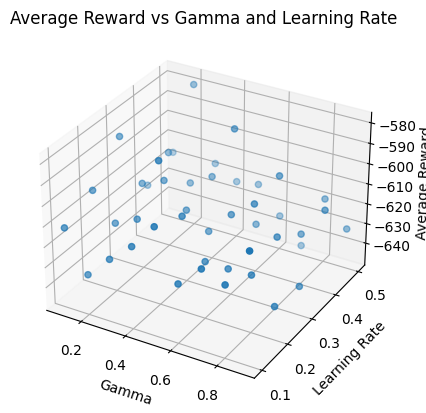

In [11]:
import matplotlib.pyplot as plt

# Extract the gamma values, learning rate values, and average rewards from the results
gamma_values = [result['gamma'] for result in results]
learning_rate_values = [result['learning_rate'] for result in results]
average_rewards = [result['average_reward'] for result in results]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gamma_values, learning_rate_values, average_rewards)

# Set labels and title
ax.set_xlabel('Gamma')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Average Reward')
ax.set_title('Average Reward vs Gamma and Learning Rate')

# Show the plot
plt.show()


[*] average times exceeded mean delay: 1.12
[*] average times popped from empty queue: 0.08
[*] average times cleared all three queues: 2.0
[*] Average Score: 132.6


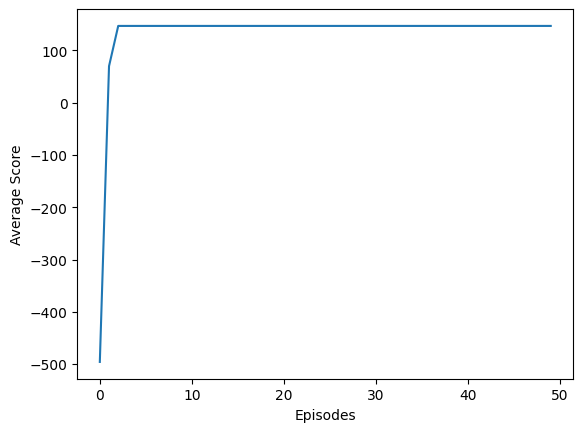

In [13]:
# Play the Game
env = TrafficGenerator(0.3,0.4,0.4)
action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
train_model(0.2,0.5, 1500)

def test_model():
    rewards = []
    total_penalties = 0
    total_big_penalties = 0
    total_full_clear = 0
    for episode in range(total_test_episodes):
        total_rewards = 0
        state = env.reset()
    #     print('='*40)
    #     print("[*] Episode", episode)
    #     print('='*40)

        for step in range(max_steps):
            env.render()
            action = np.argmax(qtable[state, :])
            state, reward, done, info = env.step(action)
    #         print(reward)
            if reward == -10:
                total_penalties += 1
            if reward == -25:
                total_big_penalties += 1
            if reward == 25:
                total_full_clear += 1
            total_rewards += reward
            #print("total time: {}", env.totaltime)
            
            if done:
                rewards.append(total_rewards)
                break
    print("[*] average times exceeded mean delay:", total_penalties/total_test_episodes)
    print("[*] average times popped from empty queue:", total_big_penalties/total_test_episodes)
    print("[*] average times cleared all three queues:", total_full_clear/total_test_episodes)
    print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))
    plt.plot(rewards)
    # Show the plot\n",

    plt.xlabel('Episodes')
    plt.ylabel('Average Score')

    plt.show()

env.change_arrival_rates(0.3,0.4,0.4)
test_model()
env.close()

